<a href="https://colab.research.google.com/github/kadirchan/461-hw2/blob/main/e2448207_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModelForCausalLM,
    pipeline
)
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from tqdm.auto import tqdm
sns.set(style="whitegrid")
from sklearn.utils import resample


In [2]:
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")
else:
    print("CPU")
    device = torch.device("cpu")

GPU


In [3]:
class ParliamentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [4]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
    }


Task 1


In [5]:
ideology_train_path = '/content/drive/MyDrive/nlp/trainingset-ideology-power/orientation/orientation-tr-train.tsv'

data_ideology = pd.read_csv(ideology_train_path, sep='\t')

print("First few rows of Ideology Classification dataset:")
display(data_ideology.head())

print(f"\nTotal records in Ideology Classification dataset: {len(data_ideology)}")

First few rows of Ideology Classification dataset:


,id,speaker,sex,text,text_en,label
0,tr00000,ca2031caa4032c51980160359953d507,M,"Yeni yasama döneminin ülkemiz için, milletimiz...","Mr. President, dear lawmakers, I salute you, a...",1
1,tr00001,4cee0addb3c69f6866869b180f90d45f,M,"Sayın Başkan, değerli milletvekilleri; bugün, ...","Mr. President, members of lawmakers, as I spea...",1
2,tr00002,b3d7f76d74ec268492f8190ca123a6b2,M,"Sayın Başkanım, öncelikle yüce Meclisin Başkan...","Mr. President, I'm here to share with you the ...",1
3,tr00003,722efac7138c8197a9d1e97eed3a8b18,M,24’üncü Dönem Meclis Başkanlığına seçilmenizde...,"Mr. President, under the principles determined...",1
4,tr00004,be82a4ade406ec6774a0a2e38f6957e3,M,24’üncü Yasama Dönemimizin tüm milletvekilleri...,"Mr. President, dear lawmakers, I ask God's mer...",1



Total records in Ideology Classification dataset: 16138


In [6]:
train_data_ideology, test_data_ideology = train_test_split(
    data_ideology,
    test_size=0.1,
    stratify=data_ideology['label'],
    random_state=42
)

print(f"Ideology Classification - Train size: {len(train_data_ideology)}, Test size: {len(test_data_ideology)}")

print("\nLabel Distribution in Training Set:")
print(train_data_ideology['label'].value_counts())
print(train_data_ideology['label'].value_counts(normalize=True))

print("\nLabel Distribution in Testing Set:")
print(test_data_ideology['label'].value_counts())
print(test_data_ideology['label'].value_counts(normalize=True))

Ideology Classification - Train size: 14524, Test size: 1614

Label Distribution in Training Set:
label
1    8451
0    6073
Name: count, dtype: int64
label
1    0.581865
0    0.418135
Name: proportion, dtype: float64

Label Distribution in Testing Set:
label
1    939
0    675
Name: count, dtype: int64
label
1    0.581784
0    0.418216
Name: proportion, dtype: float64


In [7]:
tokenizer_ideology = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_encodings_ideology = tokenizer_ideology(
    list(train_data_ideology['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings_ideology = tokenizer_ideology(
    list(test_data_ideology['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

train_dataset_ideology = ParliamentDataset(train_encodings_ideology, list(train_data_ideology['label']))
test_dataset_ideology = ParliamentDataset(test_encodings_ideology, list(test_data_ideology['label']))


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [8]:
model_ideology = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=2
)

model_ideology.to(device)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [9]:
training_args_ideology = TrainingArguments(
output_dir='./results_ideology',
num_train_epochs=5,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
fp16= True if torch.cuda.is_available() else False,
eval_strategy="epoch",
save_strategy="epoch",
learning_rate=2e-5,
report_to="tensorboard"
)

trainer_ideology = Trainer(
    model=model_ideology,
    args=training_args_ideology,
    train_dataset=train_dataset_ideology,
    eval_dataset=test_dataset_ideology,
    compute_metrics=compute_metrics,
)

trainer_ideology.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.518300,0.381023,0.832094,0.831258
2,0.338300,0.369828,0.845105,0.844313
3,0.247100,0.431483,0.835812,0.835615
4,0.170800,0.545654,0.846964,0.847189
5,0.106200,0.710244,0.848203,0.848281


TrainOutput(global_step=4540, training_loss=0.2687936095939334, metrics={'train_runtime': 282.9667, 'train_samples_per_second': 256.638, 'train_steps_per_second': 16.044, 'total_flos': 9553562420121600.0, 'train_loss': 0.2687936095939334, 'epoch': 5.0})

In [10]:
eval_results_ideology = trainer_ideology.evaluate()

predictions_ideology = trainer_ideology.predict(test_dataset_ideology)
pred_labels_ideology = np.argmax(predictions_ideology.predictions, axis=1)

print(classification_report(
    predictions_ideology.label_ids,
    pred_labels_ideology,
    target_names=['Left (0)', 'Right (1)']
))
trainer_ideology.save_model("./best_model_ideology")


              precision    recall  f1-score   support

    Left (0)       0.82      0.82      0.82       675
   Right (1)       0.87      0.87      0.87       939

    accuracy                           0.85      1614
   macro avg       0.84      0.84      0.84      1614
weighted avg       0.85      0.85      0.85      1614



Task 1 Balanced

In [11]:
majority_class = train_data_ideology[train_data_ideology['label'] == 1]
minority_class = train_data_ideology[train_data_ideology['label'] == 0]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

train_data_ideology_balanced = pd.concat([majority_undersampled, minority_class])

print("Balanced Training Set:")
print(train_data_ideology_balanced['label'].value_counts())
print(train_data_ideology_balanced['label'].value_counts(normalize=True))

majority_class = test_data_ideology[test_data_ideology['label'] == 1]
minority_class = test_data_ideology[test_data_ideology['label'] == 0]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

test_data_ideology_balanced = pd.concat([majority_undersampled, minority_class])

print("Balanced Training Set:")
print(test_data_ideology_balanced['label'].value_counts())
print(test_data_ideology_balanced['label'].value_counts(normalize=True))



Balanced Training Set:
label
1    6073
0    6073
Name: count, dtype: int64
label
1    0.5
0    0.5
Name: proportion, dtype: float64
Balanced Training Set:
label
1    675
0    675
Name: count, dtype: int64
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [12]:
train_encodings_ideology = tokenizer_ideology(
    list(train_data_ideology_balanced['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings_ideology = tokenizer_ideology(
    list(test_data_ideology_balanced['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

train_dataset_ideology_balanced = ParliamentDataset(train_encodings_ideology, list(train_data_ideology_balanced['label']))
test_dataset_ideology_balanced = ParliamentDataset(test_encodings_ideology, list(test_data_ideology_balanced['label']))

In [13]:
training_args_ideology = TrainingArguments(
output_dir='./results_ideology',
num_train_epochs=5,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
fp16= True if torch.cuda.is_available() else False,
eval_strategy="epoch",
save_strategy="epoch",
learning_rate=2e-5,
report_to="tensorboard"
)

trainer_ideology_balanced = Trainer(
    model=model_ideology,
    args=training_args_ideology,
    train_dataset=train_dataset_ideology_balanced,
    eval_dataset=test_dataset_ideology_balanced,
    compute_metrics=compute_metrics,
)

trainer_ideology_balanced.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.207800,0.679867,0.826667,0.825632
2,0.143600,0.803596,0.842963,0.842962
3,0.088900,0.863921,0.845926,0.845486
4,0.046000,1.009951,0.845185,0.845184
5,0.023700,1.085602,0.842222,0.842212


TrainOutput(global_step=3800, training_loss=0.10231488616842972, metrics={'train_runtime': 242.4242, 'train_samples_per_second': 250.511, 'train_steps_per_second': 15.675, 'total_flos': 7989367196006400.0, 'train_loss': 0.10231488616842972, 'epoch': 5.0})

In [14]:
eval_results_ideology = trainer_ideology_balanced.evaluate()

predictions_ideology = trainer_ideology_balanced.predict(test_dataset_ideology_balanced)
pred_labels_ideology = np.argmax(predictions_ideology.predictions, axis=1)

print(classification_report(
    predictions_ideology.label_ids,
    pred_labels_ideology,
    target_names=['Left (0)', 'Right (1)']
))
trainer_ideology_balanced.save_model("./best_model_ideology_balanced")

              precision    recall  f1-score   support

    Left (0)       0.84      0.85      0.84       675
   Right (1)       0.85      0.83      0.84       675

    accuracy                           0.84      1350
   macro avg       0.84      0.84      0.84      1350
weighted avg       0.84      0.84      0.84      1350



Task 2

In [15]:
power_train_path = '/content/drive/MyDrive/nlp/trainingset-ideology-power/power/power-tr-train.tsv'

data_power = pd.read_csv(power_train_path, sep='\t')

print("First few rows of Power Identification dataset:")
display(data_power.head())

print("\nDataset Information:")
print(data_power.info())

print(f"\nTotal records in Power Identification dataset: {len(data_power)}")

First few rows of Power Identification dataset:


,id,speaker,sex,text,text_en,label
0,tr18146,ca2031caa4032c51980160359953d507,M,"Yeni yasama döneminin ülkemiz için, milletimiz...","Mr. President, dear lawmakers, I salute you, a...",0
1,tr18147,4cee0addb3c69f6866869b180f90d45f,M,"Sayın Başkan, değerli milletvekilleri; bugün, ...","Mr. President, members of lawmakers, as I spea...",0
2,tr18148,b3d7f76d74ec268492f8190ca123a6b2,M,"Sayın Başkanım, öncelikle yüce Meclisin Başkan...","Mr. President, I'm here to share with you the ...",0
3,tr18149,722efac7138c8197a9d1e97eed3a8b18,M,24’üncü Dönem Meclis Başkanlığına seçilmenizde...,"Mr. President, under the principles determined...",0
4,tr18150,fcc61122f3553c57ae207adeb1a1af84,M,Usul tartışmasında 2 kişi lehte 2 kişi aleyhte...,"Two in favour of two in the legal debate, Mr. ...",1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17384 entries, 0 to 17383
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       17384 non-null  object
 1   speaker  17384 non-null  object
 2   sex      17384 non-null  object
 3   text     17384 non-null  object
 4   text_en  17384 non-null  object
 5   label    17384 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 815.0+ KB
None

Total records in Power Identification dataset: 17384


In [16]:
train_data_power, test_data_power = train_test_split(
    data_power,
    test_size=0.1,
    stratify=data_power['label'],
    random_state=42
)

print(f"Power Identification - Train size: {len(train_data_power)}, Test size: {len(test_data_power)}")

print("\nLabel Distribution in Training Set:")
print(train_data_power['label'].value_counts(normalize=True))

print("\nLabel Distribution in Testing Set:")
print(test_data_power['label'].value_counts(normalize=True))

Power Identification - Train size: 15645, Test size: 1739

Label Distribution in Training Set:
label
1    0.513774
0    0.486226
Name: proportion, dtype: float64

Label Distribution in Testing Set:
label
1    0.514089
0    0.485911
Name: proportion, dtype: float64


In [17]:
tokenizer_power = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

train_encodings_power = tokenizer_power(
    list(train_data_power['text']),
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings_power = tokenizer_power(
    list(test_data_power['text']),
    truncation=True,
    padding=True,
    max_length=256
)

train_dataset_power = ParliamentDataset(train_encodings_power, list(train_data_power['label']))
test_dataset_power = ParliamentDataset(test_encodings_power, list(test_data_power['label']))


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

In [18]:
model_power = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",
    num_labels=2
)

model_power.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
training_args_power = TrainingArguments(
output_dir='./results_power',
num_train_epochs=5,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
fp16= True if torch.cuda.is_available() else False,
eval_strategy="epoch",
save_strategy="epoch",
learning_rate=2e-5,
report_to="tensorboard"
)

trainer_power = Trainer(
    model=model_power,
    args=training_args_power,
    train_dataset=train_dataset_power,
    eval_dataset=test_dataset_power,
    compute_metrics=compute_metrics,
)

trainer_power.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.407600,0.278417,0.877516,0.877264
2,0.198300,0.335130,0.892467,0.892459
3,0.117600,0.495164,0.895342,0.895214
4,0.051000,0.522993,0.899367,0.899375
5,0.028300,0.561880,0.901668,0.901687


TrainOutput(global_step=4890, training_loss=0.15311655890965997, metrics={'train_runtime': 275.7536, 'train_samples_per_second': 283.677, 'train_steps_per_second': 17.733, 'total_flos': 1.0290931152768e+16, 'train_loss': 0.15311655890965997, 'epoch': 5.0})

In [20]:
eval_results_power = trainer_power.evaluate()

print("\nEvaluation Results:")
print(eval_results_power)

predictions_power = trainer_power.predict(test_dataset_power)
pred_labels_power = np.argmax(predictions_power.predictions, axis=1)

print(classification_report(
    predictions_power.label_ids,
    pred_labels_power,
    target_names=['Left (0)', 'Right (1)']
))
trainer_power.save_model("./best_model_power")


Evaluation Results:
{'eval_loss': 0.5618804097175598, 'eval_accuracy': 0.9016676250718804, 'eval_f1': 0.9016867494488379, 'eval_runtime': 1.1573, 'eval_samples_per_second': 1502.639, 'eval_steps_per_second': 24.194, 'epoch': 5.0}
              precision    recall  f1-score   support

    Left (0)       0.89      0.91      0.90       845
   Right (1)       0.91      0.89      0.90       894

    accuracy                           0.90      1739
   macro avg       0.90      0.90      0.90      1739
weighted avg       0.90      0.90      0.90      1739



Task 2 Balanced

In [21]:
majority_class = train_data_power[train_data_power['label'] == 1]
minority_class = train_data_power[train_data_power['label'] == 0]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

train_data_power_balanced = pd.concat([majority_undersampled, minority_class])

print("Balanced Training Set:")
print(train_data_power_balanced['label'].value_counts())
print(train_data_power_balanced['label'].value_counts(normalize=True))

majority_class = test_data_power[test_data_power['label'] == 1]
minority_class = test_data_power[test_data_power['label'] == 0]

majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

test_data_power_balanced = pd.concat([majority_undersampled, minority_class])

print("Balanced Training Set:")
print(test_data_power_balanced['label'].value_counts())
print(test_data_power_balanced['label'].value_counts(normalize=True))



Balanced Training Set:
label
1    7607
0    7607
Name: count, dtype: int64
label
1    0.5
0    0.5
Name: proportion, dtype: float64
Balanced Training Set:
label
1    845
0    845
Name: count, dtype: int64
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [22]:
train_encodings_power = tokenizer_power(
    list(train_data_power_balanced['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings_power = tokenizer_power(
    list(test_data_power_balanced['text_en']),
    truncation=True,
    padding=True,
    max_length=256
)

train_dataset_power_balanced = ParliamentDataset(train_encodings_power, list(train_data_power_balanced['label']))
test_dataset_power_balanced = ParliamentDataset(test_encodings_power, list(test_data_power_balanced['label']))

In [23]:
training_args_power = TrainingArguments(
output_dir='./results_power',
num_train_epochs=5,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
fp16= True if torch.cuda.is_available() else False,
eval_strategy="epoch",
save_strategy="epoch",
learning_rate=2e-5,
report_to="tensorboard"
)

trainer_power_balanced = Trainer(
    model=model_power,
    args=training_args_power,
    train_dataset=train_dataset_power_balanced,
    eval_dataset=test_dataset_power_balanced,
    compute_metrics=compute_metrics,
)

trainer_power_balanced.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.587500,0.466007,0.766864,0.763137
2,0.418700,0.416163,0.798817,0.797961
3,0.321000,0.432834,0.818935,0.818922
4,0.234900,0.506406,0.824852,0.824852
5,0.180000,0.622068,0.819527,0.819189


TrainOutput(global_step=4755, training_loss=0.34019252243603565, metrics={'train_runtime': 270.5597, 'train_samples_per_second': 281.158, 'train_steps_per_second': 17.575, 'total_flos': 1.00074289906176e+16, 'train_loss': 0.34019252243603565, 'epoch': 5.0})

In [24]:
eval_results_power = trainer_power_balanced.evaluate()

predictions_power = trainer_power_balanced.predict(test_dataset_power_balanced)
pred_labels_power = np.argmax(predictions_power.predictions, axis=1)

print(classification_report(
    predictions_power.label_ids,
    pred_labels_power,
    target_names=['Left (0)', 'Right (1)']
))
trainer_power_balanced.save_model("./best_model_power_balanced")

              precision    recall  f1-score   support

    Left (0)       0.79      0.86      0.83       845
   Right (1)       0.85      0.78      0.81       845

    accuracy                           0.82      1690
   macro avg       0.82      0.82      0.82      1690
weighted avg       0.82      0.82      0.82      1690



zero shot


In [ ]:
causal_model_name = "meta-llama/Llama-3.1-8B-Instruct"

causal_tokenizer = AutoTokenizer.from_pretrained(causal_model_name)
causal_model = AutoModelForCausalLM.from_pretrained(
    causal_model_name,
    device_map="auto" if torch.cuda.is_available() else None,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
generator = pipeline(
    "text-generation",
    model=causal_model,
    tokenizer=causal_tokenizer,
    device_map="auto",
)
print("Causal language model loaded successfully.")

Device set to use cuda:0


Causal language model loaded successfully.


In [ ]:
def zero_shot_classify_speech(text, task="ideology"):
    if task == "ideology":
        prompt = f"""
You are a political analyst. Analyze the following parliamentary speech and determine the speaker's party ideology.
Respond with a single digit:
0 - Left-leaning
1 - Right-leaning

Speech:
{text}

Answer:
"""
    elif task == "power":
        prompt = f"""
You are a political analyst. Analyze the following parliamentary speech and determine the speaker's party status.
Respond with a single digit:
0 - Governing/Coalition
1 - Opposition

Speech:
{text}

Answer:
"""
    try:

        output = generator(
            prompt,
            max_new_tokens=10,
            num_return_sequences=1,
            pad_token_id=causal_tokenizer.eos_token_id
        )

        generated_text = output[0]['generated_text']
        answer_part = generated_text.split("Answer:")[-1].strip()

        if answer_part and answer_part[0] in ["0", "1"]:
            return answer_part[0]
        else:
            return "N/A"
    except Exception as e:
        print(f"Error during generation: {e}")
        return "N/A"


In [ ]:
def evaluate_zero_shot_with_progress(df_test, text_col, task="ideology"):
    preds = []
    labels = df_test['label'].tolist()

    for i, row in tqdm(df_test.iterrows(), total=df_test.shape[0], desc=f"Classifying {task}"):
        speech_text = row[text_col]
        pred_label = zero_shot_classify_speech(speech_text, task=task)
        preds.append(pred_label)

    preds_clean = [int(p) if p in ["0", "1"] else None for p in preds]

    valid_indices = [i for i, p in enumerate(preds_clean) if p is not None]
    valid_preds = [preds_clean[i] for i in valid_indices]
    valid_labels = [labels[i] for i in valid_indices]

    acc = accuracy_score(valid_labels, valid_preds)
    f1 = f1_score(valid_labels, valid_preds, average='weighted')

    return {'accuracy': acc, 'f1_score': f1}

In [ ]:
print("\nLLM for Task 1 (Ideology) on 'text_en'...")
zero_shot_results_task1_text_en = evaluate_zero_shot_with_progress(
    test_data_ideology,
    text_col="text_en",
    task="ideology"
)
print("\nZero-Shot Results for Task 1 (Ideology) on 'text_en':")
print(zero_shot_results_task1_text_en)


LLM for Task 1 (Ideology) on 'text_en'...


Classifying ideology:   0%|          | 0/1614 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Zero-Shot Results for Task 1 (Ideology) on 'text_en':
{'accuracy': 0.5892193308550185, 'f1_score': 0.48011645514412155}


In [ ]:
print("\nLLM for Task 1 (Ideology) on 'text'...")
zero_shot_results_task1_text = evaluate_zero_shot_with_progress(
    test_data_ideology,
    text_col="text",
    task="ideology"
)
print("\nZero-Shot Results for Task 1 (Ideology) on 'text':")
print(zero_shot_results_task1_text)


LLM for Task 1 (Ideology) on 'text'...


Classifying ideology:   0%|          | 0/1614 [00:00<?, ?it/s]


Zero-Shot Results for Task 1 (Ideology) on 'text':
{'accuracy': 0.590458488228005, 'f1_score': 0.4696347405692467}


In [ ]:
print("\nLLM for Task 2 (Power Identification) on 'text_en'...")
zero_shot_results_task2_text_en = evaluate_zero_shot_with_progress(
    test_data_power,
    text_col="text_en",
    task="power"
)
print("\nZero-Shot Results for Task 2 (Power Identification) on 'text_en':")
print(zero_shot_results_task2_text_en)


LLM for Task 2 (Power Identification) on 'text_en'...


Classifying power:   0%|          | 0/1739 [00:00<?, ?it/s]


Zero-Shot Results for Task 2 (Power Identification) on 'text_en':
{'accuracy': 0.5140885566417481, 'f1_score': 0.3491038128657219}


In [ ]:
print("\nLLM for Task 2 (Power Identification) on 'text'...")
zero_shot_results_task2_text = evaluate_zero_shot_with_progress(
    test_data_power,
    text_col="text",
    task="power"
)
print("\nZero-Shot Results for Task 2 (Power Identification) on 'text':")
print(zero_shot_results_task2_text)



LLM for Task 2 (Power Identification) on 'text'...


Classifying power:   0%|          | 0/1739 [00:00<?, ?it/s]


Zero-Shot Results for Task 2 (Power Identification) on 'text':
{'accuracy': 0.5143843498273878, 'f1_score': 0.3494373926638942}


In [ ]:
results = [
    {
        'Model': 'BERT-Turkish (Fine-Tuned)',
        'Text Column': 'text',
        'Task': 'Power Identification',
        'Accuracy': eval_results_power['eval_accuracy'],
        'F1 Score': eval_results_power['eval_f1']
    },
    {
        'Model': 'BERT-Multilingual (Fine-Tuned)',
        'Text Column': 'text_en',
        'Task': 'Ideology Classification',
        'Accuracy': eval_results_ideology['eval_accuracy'],
        'F1 Score': eval_results_ideology['eval_f1']
    },
    {
        'Model': 'Llama (Zero-Shot)',
        'Text Column': 'text_en',
        'Task': 'Ideology Classification',
        'Accuracy': zero_shot_results_task1_text_en['accuracy'],
        'F1 Score': zero_shot_results_task1_text_en['f1_score']
    },
    {
        'Model': 'Llama (Zero-Shot)',
        'Text Column': 'text',
        'Task': 'Ideology Classification',
        'Accuracy': zero_shot_results_task1_text['accuracy'],
        'F1 Score': zero_shot_results_task1_text['f1_score']
    },
    {
        'Model': 'Llama (Zero-Shot)',
        'Text Column': 'text_en',
        'Task': 'Power Identification',
        'Accuracy': zero_shot_results_task2_text_en['accuracy'],
        'F1 Score': zero_shot_results_task2_text_en['f1_score']
    },
    {
        'Model': 'Llama (Zero-Shot)',
        'Text Column': 'text',
        'Task': 'Power Identification',
        'Accuracy': zero_shot_results_task2_text['accuracy'],
        'F1 Score': zero_shot_results_task2_text['f1_score']
    },
]
results_df = pd.DataFrame(results)
display(results_df)


,Model,Text Column,Task,Accuracy,F1 Score
0,BERT-Turkish (Fine-Tuned),text,Power Identification,0.907993,0.908009
1,BERT-Multilingual (Fine-Tuned),text_en,Ideology Classification,0.846344,0.846312
2,Llama (Zero-Shot),text_en,Ideology Classification,0.589219,0.480116
3,Llama (Zero-Shot),text,Ideology Classification,0.590458,0.469635
4,Llama (Zero-Shot),text_en,Power Identification,0.514089,0.349104
5,Llama (Zero-Shot),text,Power Identification,0.514384,0.349437


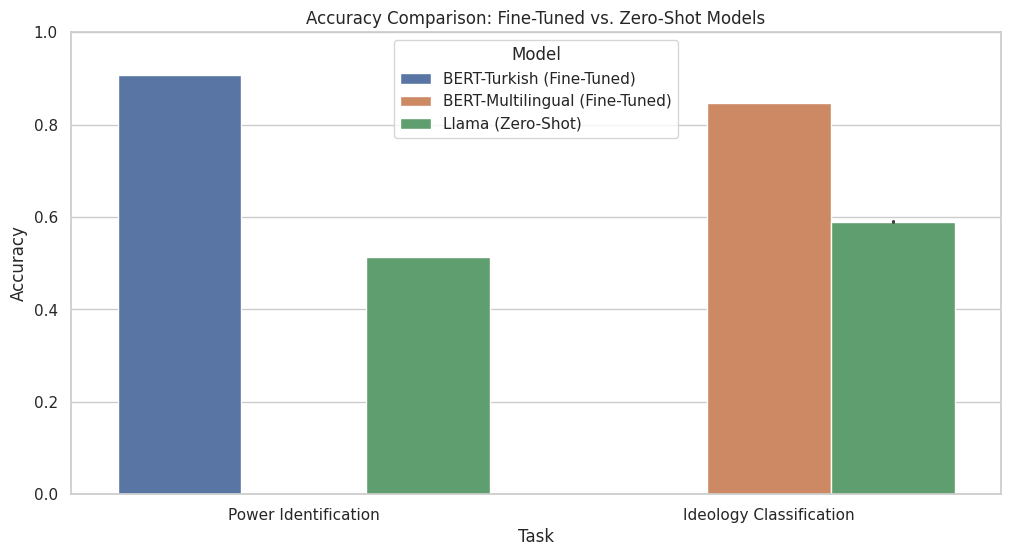

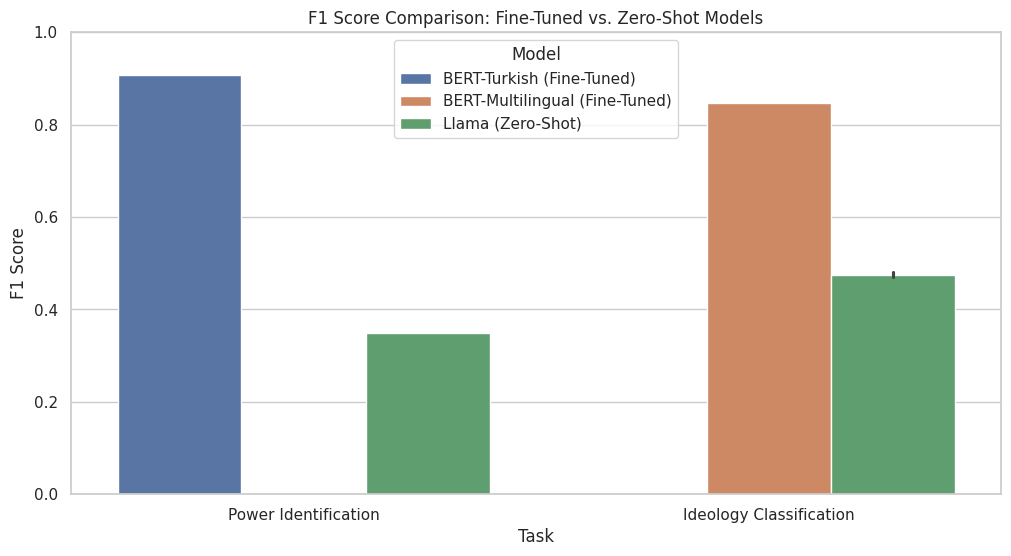

('./tokenizer_ideology/tokenizer_config.json',
 './tokenizer_ideology/special_tokens_map.json',
 './tokenizer_ideology/vocab.txt',
 './tokenizer_ideology/added_tokens.json',
 './tokenizer_ideology/tokenizer.json')

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='Accuracy', hue='Model', data=results_df)
plt.title('Accuracy Comparison: Fine-Tuned vs. Zero-Shot Models')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='F1 Score', hue='Model', data=results_df)
plt.title('F1 Score Comparison: Fine-Tuned vs. Zero-Shot Models')
plt.ylim(0, 1)
plt.show()

results_df.to_csv("comparative_results.csv", index=False)

trainer_power.save_model("./best_model_power")
trainer_ideology.save_model("./best_model_ideology")
tokenizer_power.save_pretrained("./tokenizer_power")
tokenizer_ideology.save_pretrained("./tokenizer_ideology")
